In [1]:
#!/usr/bin/python3
from sklearn.svm import OneClassSVM
import pandas as pd
import feather
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle
np.random.seed(500)
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold

In [3]:
pickle_in = open("df_lemma.pickle","rb")
df = pickle.load(pickle_in)
# df = pd.read_table("Data/YelpChi/output_review_yelpHotelData_NRYRcleaned.txt",header=None)
# df2 = pd.read_table("Data/YelpChi/output_meta_yelpHotelData_NRYRcleaned.txt",header=None, sep=" ")
# df['label'] =  df2[4]
# df['label'] = df['label'].replace(['N'],1)
# df['label'] = df['label'].replace(['Y'],-1)
# df.columns = ['review_content', 'label']

In [4]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized,text_final
0,923,0,2014-12-08,3.0,-1,the food at snack is a selection of popular gr...,42,"[the, food, at, snack, is, a, selection, of, p...","['food', 'snack', 'selection', 'popular', 'gre..."
1,923,19,2014-01-14,5.0,-1,the restaurant is on the ground floor of a typ...,95,"[the, restaurant, is, on, the, ground, floor, ...","['restaurant', 'ground', 'floor', 'typical', '..."
2,923,63,2014-11-13,4.0,-1,i really enjoyed brunch at jane. the ambiance ...,35,"[i, really, enjoyed, brunch, at, jane, ., the,...","['really', 'enjoy', 'brunch', 'jane', 'ambianc..."
3,923,100,2014-03-05,4.0,-1,clinton street baking is a super popular baker...,65,"[clinton, street, baking, is, a, super, popula...","['clinton', 'street', 'baking', 'super', 'popu..."
4,923,103,2014-07-28,5.0,-1,thiru has wonderful personality. he has a very...,18,"[thiru, has, wonderful, personality, ., he, ha...","['thiru', 'wonderful', 'personality', 'loyal',..."
...,...,...,...,...,...,...,...,...,...
181350,161143,349,2014-02-19,5.0,1,get the fried brussel sprouts. get the emily p...,55,"[get, the, fried, brussel, sprouts, ., get, th...","['get', 'fried', 'brussel', 'sprout', 'get', '..."
181351,161144,349,2014-02-11,5.0,1,the food was perfect. the wine was perfect. th...,78,"[the, food, was, perfect, ., the, wine, was, p...","['food', 'perfect', 'wine', 'perfect', 'atmosp..."
181352,161145,349,2014-02-09,5.0,1,came here for sunday brunch. everything we tas...,45,"[came, here, for, sunday, brunch, ., everythin...","['come', 'sunday', 'brunch', 'everything', 'ta..."
181353,161146,349,2014-02-06,5.0,1,"i'm very spoiled with pizza. really, i have tr...",280,"[i, 'm, very, spoiled, with, pizza, ., really,...","['spoil', 'pizza', 'really', 'try', 'lucali', ..."


In [5]:
pos=0 
neg = 0

for x in df['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  19174  positive: 162181 total 181355 percent deceptive 10.572633784566182


In [6]:
#file_path = '/home/parallels/KTH/II2202/Data/YelpNYC/database_feather.feather'
#df = pd.read_feather(file_path, columns=None, use_threads=True)

In [7]:
df.dtypes

user_id             int32
prod_id             int32
date               object
rating            float64
label               int32
review_content     object
word_count          int32
tokenized          object
text_final         object
dtype: object

In [8]:
df.describe()

,user_id,prod_id,rating,label,word_count
count,181355.000000,181355.000000,181355.000000,181355.000000,181355.000000
mean,53637.327380,454.388867,4.025205,0.788547,240.641273
std,45732.857076,260.687294,1.057903,0.614976,2992.140353
min,923.000000,0.000000,1.000000,-1.000000,1.000000
25%,13917.000000,245.000000,4.000000,1.000000,46.000000
50%,39608.000000,465.000000,4.000000,1.000000,89.000000
75%,86406.000000,668.000000,5.000000,1.000000,158.000000
max,161147.000000,922.000000,5.000000,1.000000,212038.000000


In [9]:
# # Step - a : Remove blank rows if any.
# df['review_content'].dropna(inplace=True)

In [10]:
# # Step - b : Change all the text to lower case
# df['review_content'] = [entry.lower() for entry in df['review_content']]

In [11]:
# # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
# # tokenized = []
# # for index,entry in enumerate(genuine['review_content']): 
# #     genuine.loc[index,'tokenized'] = [word_tokenize(entry)]
# #     percent = index/len(genuine)*100
# #     print('percent done [%d%%]\r'%percent, end="")
# df['tokenized']= [word_tokenize(entry) for entry in df['review_content']]

In [12]:
# # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
# final_text = [None]*len(df['tokenized'])
# for index,entry in enumerate(df['tokenized']):
#     # Declaring Empty List to store the words that follow the rules for this step
#     Final_words = []
#     # Initializing WordNetLemmatizer()
#     percent = float(index/len(df['tokenized'])*100)

#     print('percent done [%f%%]\r'%percent, end="")
#     word_Lemmatized = WordNetLemmatizer()
#     # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
#     for word, tag in pos_tag(entry):
#         # Below condition is to check for Stop words and consider only alphabets
#         if word not in stopwords.words('english') and word.isalpha():
#             word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
#             Final_words.append(word_Final)
#     # The final processed set of words for each iteration will be stored in 'text_final'
#     df.loc[index,'text_final'] = str(Final_words)
#     final_text[index]=(Final_words)
    


In [13]:
# #to save the preporcessed list

# pickle_out = open("df_lemma_yelp_chicago.pickle","wb")
# pickle.dump(df, pickle_out)
# pickle_out.close()

In [14]:
x = df['text_final'].values.reshape(-1,1)
y = df['label'].values.reshape(-1,1)
y.shape

(181355, 1)

In [15]:
#undersample = RandomUnderSampler(sampling_strategy='majority')
undersample = RandomUnderSampler(sampling_strategy='majority')
#oversample = RandomOverSampler(sampling_strategy='minority')
X_under, y_under = undersample.fit_resample(x, y)
#X_over, y_over = oversample.fit_resample(X, df['label'])

In [16]:
d = {'text_final':X_under[:,0],'label':y_under[:,]}
dfu = pd.DataFrame(d)

In [17]:
dfu

,text_final,label
0,"['food', 'snack', 'selection', 'popular', 'gre...",-1
1,"['restaurant', 'ground', 'floor', 'typical', '...",-1
2,"['really', 'enjoy', 'brunch', 'jane', 'ambianc...",-1
3,"['clinton', 'street', 'baking', 'super', 'popu...",-1
4,"['thiru', 'wonderful', 'personality', 'loyal',...",-1
...,...,...
38343,"['come', 'lot', 'first', 'move', 'area', 'pork...",1
38344,"['every', 'time', 'ues', 'go', 'bite', 'often'...",1
38345,"['omg', 'one', 'waitress', 'service', 'super',...",1
38346,"['still', 'reminisce', 'wonderful', 'dining', ...",1


In [18]:
pos=0 
neg = 0
for x in dfu['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  19174  positive: 19174 total 38348 percent deceptive 50.0


In [19]:
Train_X_oc_all, Test_X_oc_all = model_selection.train_test_split(dfu[['label','text_final']],test_size=0.3)

In [20]:
# check test genuine/deceptive
pos=0 
neg = 0

for x in Test_X_oc_all['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  5760  positive: 5745 total 11505 percent deceptive 50.065189048239894


In [21]:
# split using genuine
Train_X, Test_X = model_selection.train_test_split((Train_X_oc_all.loc[(dfu['label'] == 1)]).text_final,test_size=0.3)


In [22]:
#split using deceptive
Train_X_dec, Test_X_dec = model_selection.train_test_split((Train_X_oc_all.loc[(dfu['label'] == -1)]).text_final,test_size=0.3)

In [23]:
Tfidf_vect = TfidfVectorizer(max_features=400)        
Tfidf_vect.fit(df['text_final'])

TfidfVectorizer(max_features=400)

In [24]:
#vectorizing genuine data
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [25]:
# vectorizing deceptive data
Train_X_Tfidf_dec = Tfidf_vect.transform(Train_X_dec)
Test_X_Tfidf_dec = Tfidf_vect.transform(Test_X_oc_all['text_final'])

In [26]:
# vectorizing all data
Test_X_Tfidf_all = Tfidf_vect.transform(df['text_final'])

In [27]:
Train_X_Tfidf

<9400x400 sparse matrix of type '<class 'numpy.float64'>'
	with 287192 stored elements in Compressed Sparse Row format>

In [28]:
# fit the training dataset on the classifier using [deceptive]
start_time = time.time()

clf_dec = OneClassSVM(gamma='auto', kernel='rbf', degree=5).fit(Train_X_Tfidf_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 27.07551908493042


In [29]:
# predict using deceptive
start_time = time.time()
predictions_oneclass_dec = clf_dec.predict(Test_X_Tfidf_dec)
#print(predictions_oneclass_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

elapsed_time 22.20902442932129


In [30]:
# deceptive predict count
pos=0 
neg = 0

for x in predictions_oneclass_dec:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)       

negative:  5503  positive: 6002


In [31]:
cf_matrix=confusion_matrix(Test_X_oc_all['label'], predictions_oneclass_dec*-1)
metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predictions_oneclass_dec*-1, average='weighted',zero_division=0)
print("Accuracy Score -> ",accuracy_score(predictions_oneclass_dec*-1, Test_X_oc_all['label'], normalize=True))
print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2])
#print(metrics.f1_score(Test_X_oc_all['label'], predictions_oneclass_dec*-1, average='weighted'))
#sns.heatmap(cf_matrix, annot=True)

Accuracy Score ->  0.47709691438505
percision:  0.4770275703240648  recall:  0.47709691438505  fscore:  0.4768510966509298


<AxesSubplot:>

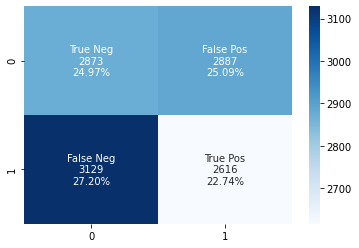

In [32]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


In [33]:
# fit the training dataset on the classifier using [genuine]
start_time = time.time()

clf_gen = OneClassSVM(gamma='auto', kernel='poly', degree=5).fit(Train_X_Tfidf)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 22.66140913963318


In [34]:
# predict using [genuine]
start_time = time.time()
predictions_oneclass_gen = clf_gen.predict(Test_X_Tfidf_dec)
#print(predictions_oneclass_gen)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

elapsed_time 23.867058992385864


In [35]:
# count of prediction using [genuine]
pos=0 
neg = 0

for x in predictions_oneclass_gen:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)   

negative:  11470  positive: 35


In [36]:
print("Accuracy Score -> ",accuracy_score(predictions_oneclass_gen, Test_X_oc_all['label'], normalize=True))

Accuracy Score ->  0.5000434593654932


In [37]:
# # to save the classifier model

# pickle_out = open("clf_oneclass.pickle","wb")
# pickle.dump(clf, pickle_out)
# pickle_out.close()

In [38]:
X_train_all, X_validation_all, Y_train_all, Y_validation_all = train_test_split(Tfidf_vect.transform(dfu['text_final']), dfu['label'], test_size=0.30, random_state=1,stratify=dfu['label'] )

In [39]:
print(len(dfu['text_final']),len(Y_train_all))

38348 26843


In [40]:
pos=0 
neg = 0
for x in Y_train_all:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  13422  positive: 13421 total 26843 percent deceptive 50.0018626830086


In [41]:
# classifier checker

# your code
models = []
#models.append(['Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr'),[],0,0])
#models.append(['Linear Discriminant Analysis', LinearDiscriminantAnalysis(),[],0,0])
#models.append(['K Nearest Neighbor', KNeighborsClassifier(),[],0,0])
#models.append(['Decesion Tree Classifier', DecisionTreeClassifier(),[],0,0])
#models.append(['Gaussien Naive Bayes', GaussianNB(),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='rbf'),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='poly'),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='linear'),[],0,0])
#models.append(['Random Forest', RandomForestClassifier(max_depth = 1000,random_state=1),[],0,0])

models = np.array(models,dtype=object)

for i in range(len(models)):
    start_time = time.time()
    #kfold = StratifiedKFold(n_splits=1, random_state=1, shuffle=True)
    cv_results = cross_val_score(models[i,1], X_train_all, Y_train_all, scoring='accuracy')
    models[i,2] = cv_results
    models[i,3] = cv_results.mean()
    models[i,4] = cv_results.std()
    elapsed_time = time.time() - start_time
    print('%s: %f (%f) elapsed time: %f' % (models[i,0], models[i,3], models[i,4],elapsed_time))
    
    

best_model= models[np.argmax(models[:,3]),:]
print("the best model performer is: ", best_model[0])

Support Vector Machine: 0.637038 (0.004064) elapsed time: 1478.434048
Support Vector Machine: 0.519501 (0.026957) elapsed time: 1443.067139
Support Vector Machine: 0.655292 (0.002103) elapsed time: 1296.440691
the best model performer is:  Support Vector Machine


In [42]:
clf_model=SVC(gamma='auto',kernel='linear',degree=2).fit(X_train_all, Y_train_all)

In [43]:
result=clf_model.predict(X_validation_all)

In [44]:
pos=0 
neg = 0
for x in result:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  6271  positive: 5234 total 11505 percent deceptive 54.50673620165146


In [45]:
print("Accuracy Score -> ",accuracy_score(result, Y_validation_all, normalize=True))
metrics_result = precision_recall_fscore_support(Y_validation_all, result, average='binary',zero_division=0)
print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n') 

Accuracy Score ->  0.6543242068665798
percision:  0.6696599159342759  recall:  0.6092473492091083  fscore:  0.6380267588968781 



In [46]:
df2= df[['text_final','label']]

In [47]:
df3= pd.concat([df2, dfu]).drop_duplicates(keep=False)

In [48]:
pos=0 
neg = 0
for x in df3['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  0  positive: 142525 total 142525 percent deceptive 0.0


In [49]:
# split using genuine
perc=(1- len(Y_train_all)/len(df3))
Train_X_oneclass, Test_X_oneclass = model_selection.train_test_split((df3.loc[(df['label'] == 1)]).text_final,test_size=perc)

In [50]:
Train_X_oneclass.shape

(26843,)

In [51]:
# max_features = 100;
# while max_features < 5000:
#     Tfidf_vect = TfidfVectorizer(max_features=max_features)        
#     Tfidf_vect.fit(df['text_final'])
#     Train_X_Tfidf = Tfidf_vect.transform(Train_X)
#     Test_X_Tfidf = Tfidf_vect.transform(Test_X)
#     Train_X_Tfidf_dec = Tfidf_vect.transform(Train_X_dec)
#     Test_X_Tfidf_dec = Tfidf_vect.transform(Test_X_oc_all['text_final'])
#     one_class_train = Tfidf_vect.transform(Train_X_oneclass)
    
#     clf_result = OneClassSVM( kernel='poly', degree=2).fit(one_class_train)
#     predict_result = clf_result.predict(Test_X_Tfidf_dec)
#     acc = accuracy_score(predict_result*1, Test_X_oc_all['label'], normalize=True)
#     metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predict_result*1, average='weighted',zero_division=0)
#     print('features used: ', max_features, ' accuracy: ', acc)
#     print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n')  
    
#     max_features += 100

In [52]:
one_class_train = Tfidf_vect.transform(Train_X_oneclass)

In [53]:
one_class_train

<26843x400 sparse matrix of type '<class 'numpy.float64'>'
	with 817399 stored elements in Compressed Sparse Row format>

In [54]:
# fit the training dataset on the classifier
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [0,1,2,3]
classifiers = []
for kern in kernels:
    start_time = time.time()
    if kern == 'poly':
        for deg in degrees:
            start_time = time.time()
            clf_result = OneClassSVM( kernel=kern, degree=deg).fit(one_class_train)
            elapsed_time = time.time() - start_time
            classifiers.append([kern,deg,clf_result,elapsed_time])
            print('kernel used: ' , kern, ' degree used: ' , deg, ' elapsed_time:' , elapsed_time)
            
    else:
        clf_result = OneClassSVM(gamma='auto', kernel=kern).fit(Train_X_Tfidf_dec)
        elapsed_time = time.time() - start_time
        classifiers.append([kern,0,clf_result,elapsed_time])
        print('kernel used: ' , kern, ' elapsed_time: ' , elapsed_time)

# predict the labels on validation dataset

kernel used:  linear  elapsed_time:  37.48553824424744
kernel used:  poly  degree used:  0  elapsed_time: 191.36246013641357
kernel used:  poly  degree used:  1  elapsed_time: 390.4933798313141
kernel used:  poly  degree used:  2  elapsed_time: 359.28795981407166
kernel used:  poly  degree used:  3  elapsed_time: 342.68660712242126
kernel used:  rbf  elapsed_time:  25.588025093078613
kernel used:  sigmoid  elapsed_time:  25.290656328201294


In [55]:
clas_result = []
for clas in classifiers:
    start_time = time.time()
    predict_result = clas[2].predict(Test_X_Tfidf_dec)
    elapsed_time = time.time() - start_time
    clas_result.append([clas[0],clas[1],clas[2],predict_result])
    acc = accuracy_score(predict_result*1, Test_X_oc_all['label'], normalize=True)
    metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predict_result*1, average='binary',zero_division=0)
    print('kernel used: ' , clas[0], ' degree used:' , clas[1], ' elapsed_time: ' , elapsed_time, ' accuracy: ', acc)
    print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n')  
# predict the labels on validation dataset

kernel used:  linear  degree used: 0  elapsed_time:  13.880253553390503  accuracy:  0.5235115167318557
percision:  0.5217535153019024  recall:  0.5489991296779808  fscore:  0.5350296861747242 

kernel used:  poly  degree used: 0  elapsed_time:  58.414499044418335  accuracy:  0.500651890482399
percision:  0.0  recall:  0.0  fscore:  0.0 

kernel used:  poly  degree used: 1  elapsed_time:  59.684990882873535  accuracy:  0.5603650586701434
percision:  0.569436021831413  recall:  0.49033942558746735  fscore:  0.5269360269360269 

kernel used:  poly  degree used: 2  elapsed_time:  61.54842567443848  accuracy:  0.5491525423728814
percision:  0.5552475247524753  recall:  0.48807658833768497  fscore:  0.5194997684113015 

kernel used:  poly  degree used: 3  elapsed_time:  69.06832194328308  accuracy:  0.5430682312038244
percision:  0.5503923998347791  recall:  0.463881636205396  fscore:  0.5034476244450741 

kernel used:  rbf  degree used: 0  elapsed_time:  15.06484842300415  accuracy:  0.5229

<AxesSubplot:>

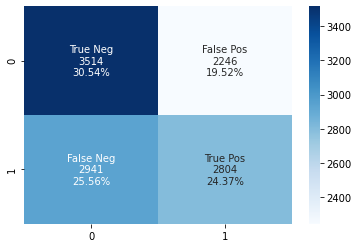

In [56]:
clf_result = OneClassSVM( kernel='poly', degree=2).fit(one_class_train)
predict_result = clf_result.predict(Test_X_Tfidf_dec)

cf_matrix=confusion_matrix(Test_X_oc_all['label'], predict_result*1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
